In [1]:
import os, sys
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = os.getcwd()
p = os.path.dirname(d)

sys.path.append(p)

In [3]:
from src.dynamics import RobotWorld
from src.lqr import Lqr
from src.algorithms.addpgpd_sampled import ADpgpdSampled
from src.algorithms.nnpgpd import Nnpgpd
from src.sampling import Sampler

In [4]:
ds = 4
da = 2

tau = 0.01
gamma = 0.9
alpha = 1.0

b = -1

In [55]:
G = - torch.tensor([
    [0.1, 0, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0.01, 0],
    [0, 0, 0, 0.01]
]).double()

R =  - torch.tensor([
    [0.1, 0],
    [0, 0.1],
]).double() * (tau / 2)

C = - torch.tensor([
    [1.0, 0],
    [0, 1.0],
]).double()

def primal_reward_fn(env, a):
    return ((env.s @ G) * env.s).sum(dim=1) + ((a @ R) * a).sum(dim=1)

def dual_reward_fn(env, a):
    return (a.abs() @ C).sum(dim=1)

def starting_pos_fn(nsamples):
        rng = np.random.default_rng()

        s = torch.tensor(rng.uniform(
            low=[1, 1, -10, -10],
            high= [100, 100, 10, 10],
            size=[nsamples, 4],
        )).double()

        a = torch.tensor(rng.uniform(
            low=[-10, -10],
            high= [10, 10],
            size=[nsamples, 2],
        )).double()

        return s, a

In [58]:
epochs = 1_000
n_pe = 100
n_rho = 1_000
n_roll = 100

gamma = 0.9
eta = 0.01

env = RobotWorld(range_pos=[-100., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

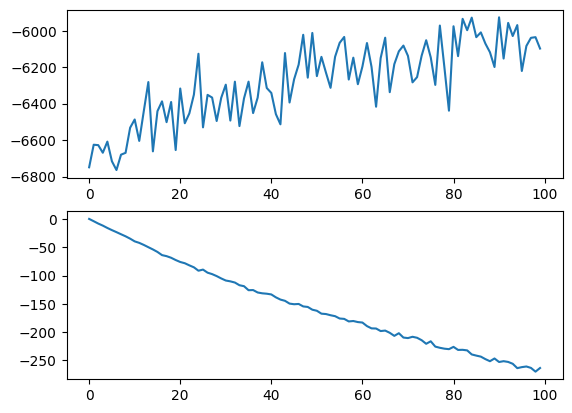

In [59]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[1].plot(losses_dual)
plt.show()

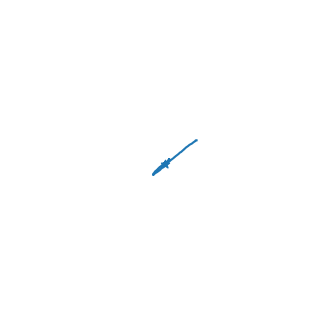

In [62]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axis('off')
plt.show()

In [63]:
epochs = 500
n_pe = 100
n_rho = 10_000
n_roll = 100

gamma = 0.9

eta = 0.01

b = - 100.0
# b -2 and eta 0.001

env = RobotWorld(range_pos=[-100., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

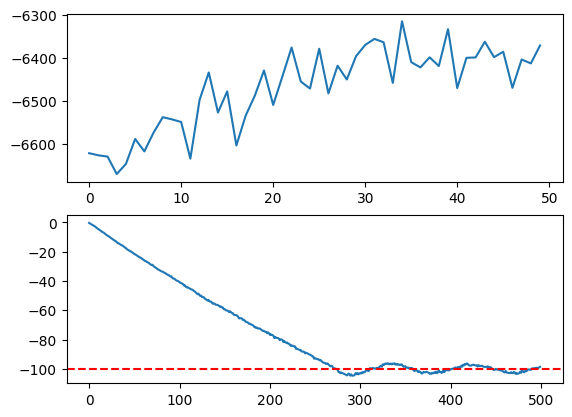

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
#axes[0].axhline(y=-910, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

In [48]:
np.save('../results/obs_primal.npy', losses_primal)
np.save('../results/obs_dual.npy', losses_dual)

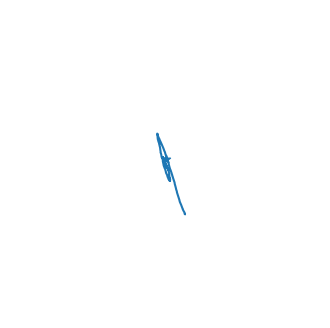

In [65]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axis('off')
plt.show()

# Neural netowrk

In [46]:
class MLPActor(torch.nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int =256) -> None:
        super(MLPActor, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

        torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=0.1)
        torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=0.1)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        x = torch.nn.functional.relu(self.fc1(state))
        action = self.fc2(x)
        return action

In [36]:
class MLPCritic(torch.nn.Module):
    def __init__(self, state_dim: int, action_dim: int, hidden_dim: int=256) -> None:
        super(MLPCritic, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim + action_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

        torch.nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
        torch.nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)

    def forward(self, state: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([state, action], dim=-1)
        x = torch.nn.functional.relu(self.fc1(x))
        q_value = self.fc2(x)
        return q_value

In [72]:
b = - 100
gamma = 0.9

n_epochs = 5_000
n_episodes = 1
n_samples = 100
n_rollout = 100
n_rho = 1_000
n_init = 10_000

num_features = 128
lr_actor = 2e-5
lr_critic = 1e-6
lr_dual = 1e-4

env = RobotWorld(range_pos=[-100., 100.], range_vel=[-.1, .1])

nnpgpd = Nnpgpd(ds, da, env, num_features, lr_actor, lr_critic, lr_dual, gamma, b, starting_pos_fn, primal_reward_fn, dual_reward_fn)
loss_primal, loss_dual = nnpgpd.train(n_epochs, n_episodes, n_samples, n_rollout, n_rho, n_init)

Initial CLoss - 95561.5060319246
Epoch 0 - Primal -6632.046508930199 - Dual -1.2678969357051628 - Lambda 0.0
Epoch 10 - Primal -6649.251471191029 - Dual -1.4008027668385632 - Lambda 0.0
Epoch 20 - Primal -6640.959542214314 - Dual -1.494083281685875 - Lambda 0.0
Epoch 30 - Primal -6653.429325343204 - Dual -1.7654923729013012 - Lambda 0.0
Epoch 40 - Primal -6727.219468812481 - Dual -2.090271797673037 - Lambda 0.0
Epoch 50 - Primal -6466.827572071555 - Dual -2.3081269995806504 - Lambda 0.0
Epoch 60 - Primal -6695.859974601599 - Dual -2.6945673699777783 - Lambda 0.0
Epoch 70 - Primal -6700.410773654691 - Dual -2.8241266732868717 - Lambda 0.0
Epoch 80 - Primal -6468.30262697418 - Dual -3.29451355344482 - Lambda 0.0
Epoch 90 - Primal -6647.650893707203 - Dual -3.8942085683525156 - Lambda 0.0
Epoch 100 - Primal -6786.590542229879 - Dual -4.097874916921275 - Lambda 0.0
Epoch 110 - Primal -6614.9885140486695 - Dual -4.470976015027859 - Lambda 0.0
Epoch 120 - Primal -6428.64403732089 - Dual -4.7

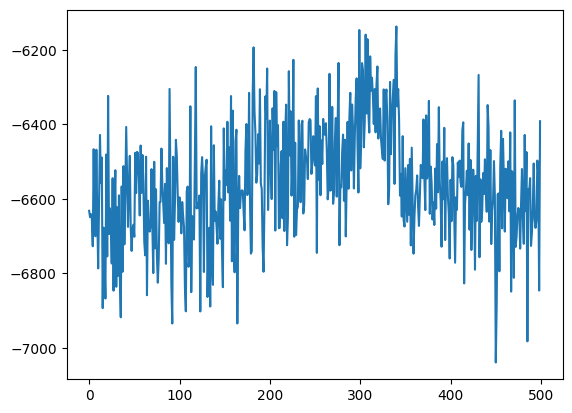

In [73]:
plt.plot(loss_primal);

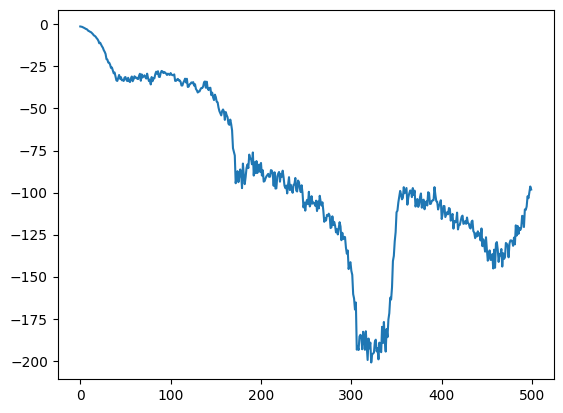

In [74]:
plt.plot(loss_dual)
#plt.ylim(-20, 0);

In [118]:
np.save('../results/obs_primal_nn.npy', loss_primal)
np.save('../results/obs_dual_nn.npy', loss_dual)

In [ ]:
G = - torch.tensor([
    [1.0, 0, 0, 0],
    [0, 1.0, 0, 0],
    [0, 0, 0.01, 0],
    [0, 0, 0, 0.01]
]).double()

R =  - torch.tensor([
    [0.1, 0],
    [0, 0.1],
]).double()

def primal_reward_fn(env, a):
    return ((env.s @ G) * env.s).sum(dim=1) + ((a @ R) * a).sum(dim=1)

def dual_reward_fn(env, a):
    #return 100 * (s[:, 0].sign().clip(max=0.0) + s[:, 1].sign().clip(max=0.0)).clip(min=-1)
    return 100 * (env.s[:, 0].clip(max=1.0) + env.s[:, 1].clip(max=1.0) - 2)

def starting_pos_fn(nsamples):
        rng = np.random.default_rng()

        s = torch.tensor(rng.uniform(
            low=[1, 1, -10, -10],
            high= [100, 100, 10, 10],
            size=[nsamples, 4],
        )).double()

        a = torch.tensor(rng.uniform(
            low=[-10, -10],
            high= [10, 10],
            size=[nsamples, 2],
        )).double()

        return s, a

In [ ]:
epochs = 300
n_pe = 100
n_rho = 1_000
n_roll = 200

gamma = 0.95
eta = 0.01

env = RobotWorld(range_pos=[1., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, losses_primal, losses_dual = dpgpd.train_unconstrained(epochs, n_pe, n_rho, n_roll)

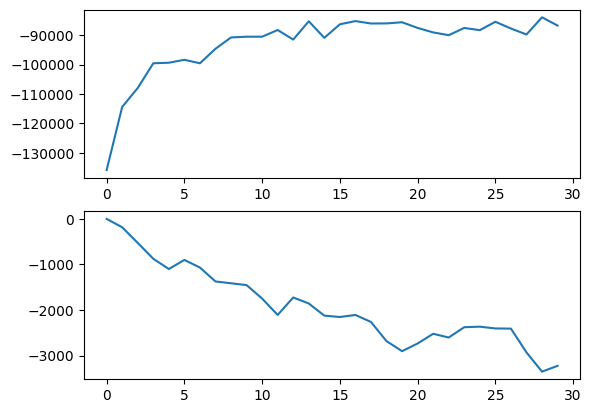

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
axes[1].plot(losses_dual)
plt.show()

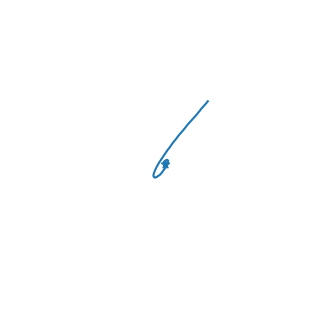

In [ ]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter([0], [0], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axis('off')
plt.show()

In [ ]:
epochs = 50_000
n_pe = 100
n_rho = 10_000
n_roll = 200

gamma = 0.95

eta = 0.00001

b = - 20.0
# b -2 and eta 0.001

env = RobotWorld(range_pos=[1., 100.], range_vel=[-.1, .1])
sampler = Sampler(env, gamma)
dpgpd = ADpgpdSampled(ds, da, env, eta, tau, gamma, b, alpha, primal_reward_fn, dual_reward_fn, starting_pos_fn)

K, lmbda, losses_primal, losses_dual = dpgpd.train_constrained(epochs, n_pe, n_rho, n_roll)

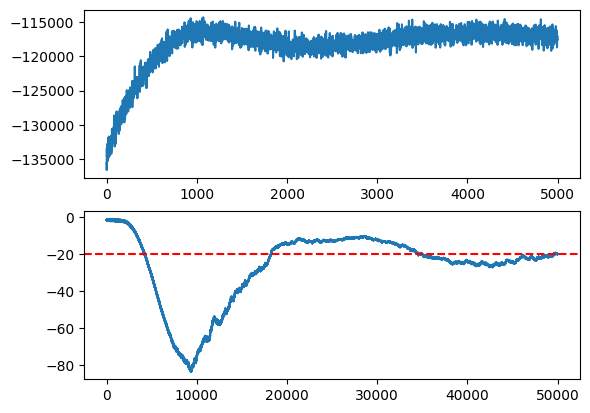

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(losses_primal)
#axes[0].axhline(y=-910, color='r', linestyle='--')
axes[1].plot(losses_dual)
axes[1].axhline(y=b, color='r', linestyle='--')
plt.show()

In [ ]:
np.save('../results/obs_primal.npy', losses_primal)
np.save('../results/obs_dual.npy', losses_dual)

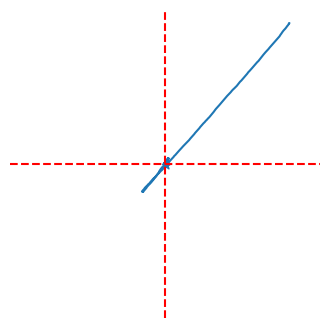

In [ ]:
T = 1000
states, actions = sampler.sample_trajectory(K, T)
plt.figure(figsize=[4, 4])
plt.scatter(states[-1, 0], states[-1, 1], marker='*')
plt.plot(states[:, 0], states[:, 1])
plt.xlim(-100, 100)
plt.ylim(-100, 100)
plt.axhline(y=0, color='r', linestyle='--')
plt.axvline(x=0, color='r', linestyle='--')
plt.axis('off')
plt.show()